# Mining Process – % Silica Concentrate Prediction - Baseline Model

This script serves as a baseline for the field model. Predicting the **% Silica Concentrate** in a mining flotation process using laboratory data, both % Iron Concentrate and % Silica Concentrate (target). The code is divided into three main parts, which are:
1. Data ingestion and preprocessing  
2. Feature selection and treatment  
3. Time-aware train-test split  
4. Model training with high correlated variables
5. Performance evaluation and result visualization (I)
6. Model training with target variable
7. Performance evaluation and result visualization (II)


**Responsible:** Paulo Casmal

**Email:** <paulo.casmal@gmail.com>

**Date:** 12-22-2025


---


## 01 - Imports & Configurations

In [116]:
# import necessary libraries
import pandas as pd
import numpy as np  
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import xgboost as xgb

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit

In [117]:
# Configuration of matplotlib parameters for consistent styling
mpl.rcParams['figure.figsize'] = (10, 6)  # Default figure size
mpl.rc('lines', lw=2)  # Sets the line width
mpl.rcParams['grid.linewidth'] = 0.5  # Grid line width
mpl.rcParams['grid.linestyle'] = 'dashed'  # Grid line style
mpl.rc(('xtick', 'ytick'), labelsize=15)  # Axis tick label size
mpl.rc('font', family='Century Gothic', size=15)  # Font family and font size
mpl.rcParams['axes.linewidth'] = 0.5 # - Largura das bordas dos gráficos

In [118]:
# Load the dataset
path = r'C:\Users\paulo\Downloads\archive (2)\MiningProcess_Flotation_Plant_Database.csv'

df = pd.read_csv(path, decimal=',')

df.head()

,date,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,...,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
0,2017-03-10 01:00:00,55.2,16.98,3019.53,557.434,395.713,10.0664,1.74,249.214,253.235,...,250.884,457.396,432.962,424.954,443.558,502.255,446.370,523.344,66.91,1.31
1,2017-03-10 01:00:00,55.2,16.98,3024.41,563.965,397.383,10.0672,1.74,249.719,250.532,...,248.994,451.891,429.560,432.939,448.086,496.363,445.922,498.075,66.91,1.31
2,2017-03-10 01:00:00,55.2,16.98,3043.46,568.054,399.668,10.0680,1.74,249.741,247.874,...,248.071,451.240,468.927,434.610,449.688,484.411,447.826,458.567,66.91,1.31
3,2017-03-10 01:00:00,55.2,16.98,3047.36,568.665,397.939,10.0689,1.74,249.917,254.487,...,251.147,452.441,458.165,442.865,446.210,471.411,437.690,427.669,66.91,1.31
4,2017-03-10 01:00:00,55.2,16.98,3033.69,558.167,400.254,10.0697,1.74,250.203,252.136,...,248.928,452.441,452.900,450.523,453.670,462.598,443.682,425.679,66.91,1.31


## 02 - Dataset treatment

In [119]:
# Convert 'date' column to datetime and set as index
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

In [120]:
df.columns

Index(['% Iron Feed', '% Silica Feed', 'Starch Flow', 'Amina Flow',
       'Ore Pulp Flow', 'Ore Pulp pH', 'Ore Pulp Density',
       'Flotation Column 01 Air Flow', 'Flotation Column 02 Air Flow',
       'Flotation Column 03 Air Flow', 'Flotation Column 04 Air Flow',
       'Flotation Column 05 Air Flow', 'Flotation Column 06 Air Flow',
       'Flotation Column 07 Air Flow', 'Flotation Column 01 Level',
       'Flotation Column 02 Level', 'Flotation Column 03 Level',
       'Flotation Column 04 Level', 'Flotation Column 05 Level',
       'Flotation Column 06 Level', 'Flotation Column 07 Level',
       '% Iron Concentrate', '% Silica Concentrate'],
      dtype='object')

In [121]:
df_iron = df[['% Iron Concentrate', '% Silica Concentrate']]
df_silica = df[['% Silica Concentrate']]

### 2.1 - Addiding Time Features

In [122]:


def create_time_features(df):
    """Create time-based features from datetime index."""
    df['day'] = df.index.day
    df['month'] = df.index.month
    df['hour'] = df.index.hour
    df['minute'] = df.index.minute
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter

    return df


df_iron = create_time_features(df_iron)
df_silica = create_time_features(df_silica)

C:\Users\paulo\AppData\Local\Temp\ipykernel_16272\4131794302.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['day'] = df.index.day
C:\Users\paulo\AppData\Local\Temp\ipykernel_16272\4131794302.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = df.index.month
C:\Users\paulo\AppData\Local\Temp\ipykernel_16272\4131794302.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

### 2.2 Cross Validation Split

In [123]:
tss = TimeSeriesSplit(n_splits=5, test_size=3*30*24*30, gap=3*30*24) # 15 days data for testing

df = df.sort_index()

TypeError: __init__() got an unexpected keyword argument 'ncols'

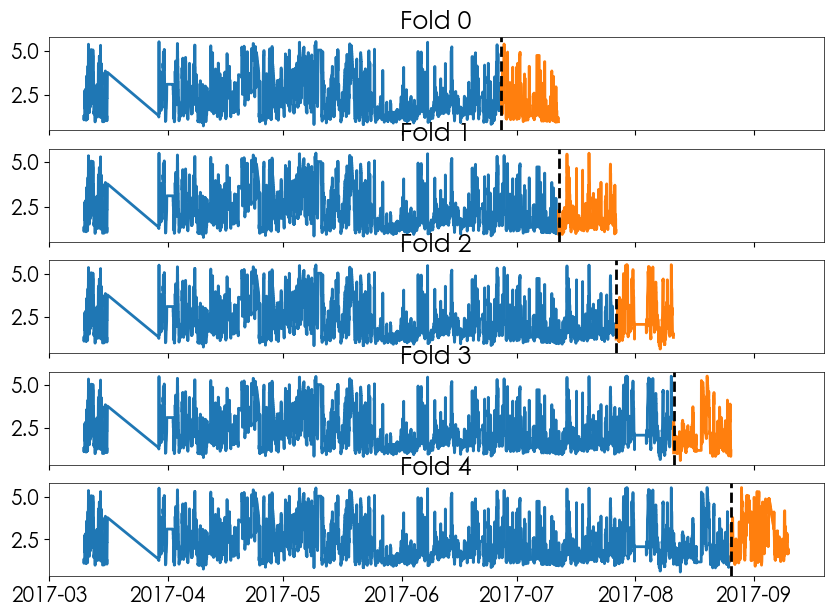

In [138]:
fig, axs = plt.subplots(5, 1, figsize=(10, 7), sharex=True)

# Plot each fold
for fold, (train_index, test_index) in enumerate(tss.split(df)):
    train = df.iloc[train_index]
    test = df.iloc[test_index]

    axs[fold].plot(train.index, train['% Silica Concentrate'], label='Train', color='tab:blue')
    axs[fold].plot(test.index, test['% Silica Concentrate'], label='Test', color='tab:orange')
    axs[fold].axvline(x=test.index[0], color='k', linestyle='--', label='Test Start')

    axs[fold].set_title(f'Fold {fold}')

axs[0].legend(ncols=3, loc='upper left', bbox_to_anchor=(1.05, 1))

plt.xlabel('Date')
plt.tight_layout()
plt.show()

## 03 - Applying XGBoost Model - Iron only 

In [125]:
scores = []
r2s = []
maes = []

for fold, (train_index, test_index) in enumerate(tss.split(df_iron)):

    train = df_iron.iloc[train_index]
    test = df_iron.iloc[test_index]

    X = train.drop(columns=['% Silica Concentrate'])
    y = train['% Silica Concentrate']

    X_test = test.drop(columns=['% Silica Concentrate'])
    y_test = test['% Silica Concentrate']

    # Split temporal interno (validação)
    split_idx = int(len(X) * 0.8)

    X_train, X_val = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_val = y.iloc[:split_idx], y.iloc[split_idx:]

    model = xgb.XGBRegressor(
        n_estimators=1000,
        learning_rate=0.01,
        max_depth=4,
        objective='reg:squarederror',
        early_stopping_rounds=50,
        random_state=42
    )

    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        verbose=100
    )

    y_pred = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    scores.append(rmse)
    r2s.append(r2)
    maes.append(mae)

    print(
        f'Fold {fold} | '
        f'RMSE: {rmse:.4f} | '
        f'R²: {r2:.4f} | '
        f'MAE: {mae:.4f}'
    )

[0]	validation_0-rmse:1.17463	validation_1-rmse:0.98452
[100]	validation_0-rmse:0.69597	validation_1-rmse:0.67991
[200]	validation_0-rmse:0.56533	validation_1-rmse:0.64360
[222]	validation_0-rmse:0.55201	validation_1-rmse:0.64960
Fold 0 | RMSE: 0.7850 | R²: 0.3897 | MAE: 0.6055
[0]	validation_0-rmse:1.14177	validation_1-rmse:1.07392
[100]	validation_0-rmse:0.68344	validation_1-rmse:0.84493
[200]	validation_0-rmse:0.56301	validation_1-rmse:0.79742
[271]	validation_0-rmse:0.52845	validation_1-rmse:0.79586
Fold 1 | RMSE: 0.5890 | R²: 0.5095 | MAE: 0.4338
[0]	validation_0-rmse:1.12385	validation_1-rmse:1.05340
[100]	validation_0-rmse:0.68200	validation_1-rmse:0.79293
[200]	validation_0-rmse:0.57204	validation_1-rmse:0.72948
[300]	validation_0-rmse:0.53206	validation_1-rmse:0.70922
[400]	validation_0-rmse:0.50724	validation_1-rmse:0.70475
[500]	validation_0-rmse:0.48829	validation_1-rmse:0.70317
[600]	validation_0-rmse:0.46931	validation_1-rmse:0.69835
[673]	validation_0-rmse:0.45929	valida

## 5. Performance evaluation and result visualization (I)

In [126]:
print(
    f'Average | '
    f'RMSE: {np.mean(scores):.4f} | '
    f'R²: {np.mean(r2s):.4f} | '
    f'MAE: {np.mean(maes):.4f}'

    f'\nBest |'
    f'RMSE: {np.min(scores):.4f} | '
    f'R²: {np.max(r2s):.4f} | '
    f'MAE: {np.min(maes):.4f}'
)

Average | RMSE: 0.6729 | R²: 0.5641 | MAE: 0.5127
Best |RMSE: 0.5890 | R²: 0.6982 | MAE: 0.4338


In [127]:
results = model.evals_result_
print(results.keys())

dict_keys(['validation_0', 'validation_1'])


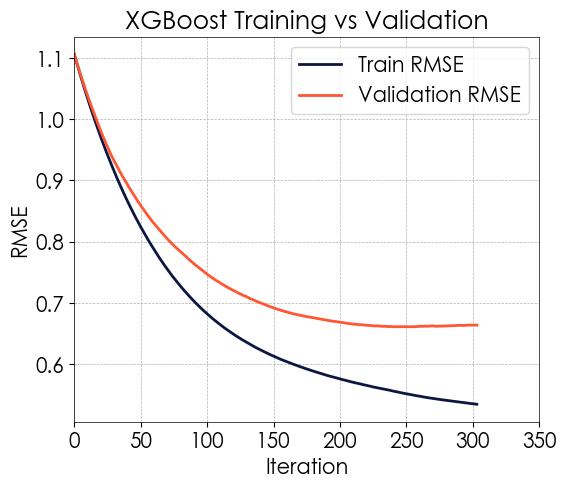

In [128]:
train_rmse = results['validation_0']['rmse']
val_rmse   = results['validation_1']['rmse']

fig_error, ax = plt.subplots(figsize=(6, 5))

ax.plot(train_rmse, label='Train RMSE', c='#0B1741')
ax.plot(val_rmse, label='Validation RMSE', c='#FF5733')

ax.set_xlabel('Iteration')
ax.set_ylabel('RMSE')
ax.set_title('XGBoost Training vs Validation')
ax.legend()

ax.grid(True)
ax.set_xlim(0, 350)

fig_error.savefig(r'G:\Meu Drive\03 - Facens\03 - Data Science\02-TCC-POS\05-Figures\bm_sc_errors_01.svg', dpi=140, format='svg')

plt.show()

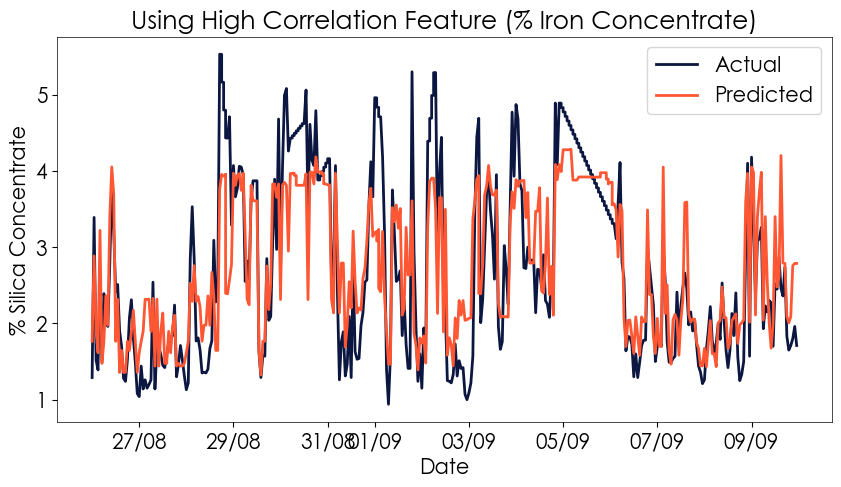

In [129]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(y_test.index, y_test, label='Actual', c='#0B1741')
ax.plot(y_test.index, y_pred, label='Predicted', c='#FF5733')   

ax.set_ylabel('% Silica Concentrate')
ax.set_xlabel('Date')
ax.legend(loc='upper right')
ax.set_title('Using High Correlation Feature (% Iron Concentrate)')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))

fig.savefig(r'G:\Meu Drive\03 - Facens\03 - Data Science\02-TCC-POS\05-Figures\bm_sc_prediction_01.svg', dpi=140, format='svg')

plt.show()

## 6. Model training with target variable

In [130]:
scores = []
r2s = []
maes = []

for fold, (train_index, test_index) in enumerate(tss.split(df_silica)):

    train = df_silica.iloc[train_index]
    test = df_silica.iloc[test_index]

    X = train
    y = train['% Silica Concentrate']

    X_test = test
    y_test = test['% Silica Concentrate']

    # Split temporal interno (validação)
    split_idx = int(len(X) * 0.8)

    X_train, X_val = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_val = y.iloc[:split_idx], y.iloc[split_idx:]

    model = xgb.XGBRegressor(
        n_estimators=1000,
        learning_rate=0.01,
        max_depth=4,
        objective='reg:squarederror',
        early_stopping_rounds=50,
        random_state=42
    )

    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)], 
        verbose=100
    )

    y_pred = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    scores.append(rmse)
    r2s.append(r2)
    maes.append(mae)

    print(
        f'Fold {fold} | '
        f'RMSE: {rmse:.4f} | '
        f'R²: {r2:.4f} | '
        f'MAE: {mae:.4f}'
    )

[0]	validation_0-rmse:1.17152	validation_1-rmse:0.98098
[100]	validation_0-rmse:0.43105	validation_1-rmse:0.36160
[200]	validation_0-rmse:0.15893	validation_1-rmse:0.13339
[300]	validation_0-rmse:0.05908	validation_1-rmse:0.04969
[400]	validation_0-rmse:0.02304	validation_1-rmse:0.01953
[500]	validation_0-rmse:0.01115	validation_1-rmse:0.00972
[600]	validation_0-rmse:0.00802	validation_1-rmse:0.00736
[700]	validation_0-rmse:0.00718	validation_1-rmse:0.00682
[800]	validation_0-rmse:0.00686	validation_1-rmse:0.00670
[900]	validation_0-rmse:0.00656	validation_1-rmse:0.00655
[997]	validation_0-rmse:0.00640	validation_1-rmse:0.00653
Fold 0 | RMSE: 0.0068 | R²: 1.0000 | MAE: 0.0037
[0]	validation_0-rmse:1.13857	validation_1-rmse:1.06813
[100]	validation_0-rmse:0.41899	validation_1-rmse:0.39072
[200]	validation_0-rmse:0.15451	validation_1-rmse:0.14316
[300]	validation_0-rmse:0.05748	validation_1-rmse:0.05251
[400]	validation_0-rmse:0.02252	validation_1-rmse:0.01990
[500]	validation_0-rmse:0.0

## 7. Performance evaluation and result visualization (II)

In [131]:
print(
    f'Average | '
    f'RMSE: {np.mean(scores):.4f} | '
    f'R²: {np.mean(r2s):.4f} | '
    f'MAE: {np.mean(maes):.4f}'

    f'\nBest |'
    f'RMSE: {np.min(scores):.4f} | '
    f'R²: {np.max(r2s):.4f} | '
    f'MAE: {np.min(maes):.4f}'
)

Average | RMSE: 0.0130 | R²: 0.9998 | MAE: 0.0054
Best |RMSE: 0.0068 | R²: 1.0000 | MAE: 0.0037


In [132]:
results = model.evals_result_
print(results.keys())

dict_keys(['validation_0', 'validation_1'])


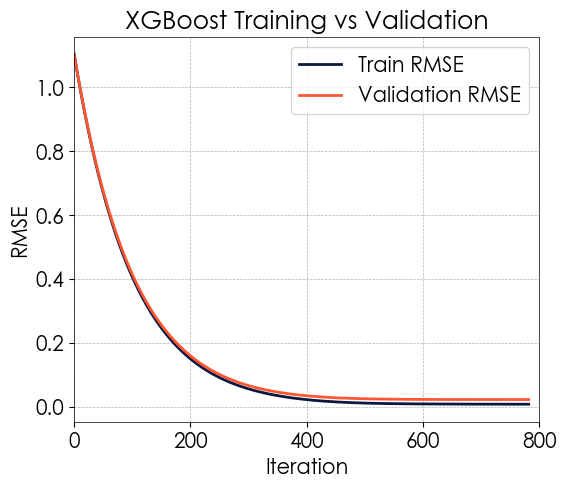

In [133]:
train_rmse = results['validation_0']['rmse']
val_rmse   = results['validation_1']['rmse']

fig_error, ax = plt.subplots(figsize=(6, 5))

ax.plot(train_rmse, label='Train RMSE', c='#0B1741')
ax.plot(val_rmse, label='Validation RMSE', c='#FF5733')

ax.set_xlabel('Iteration')
ax.set_ylabel('RMSE')
ax.set_title('XGBoost Training vs Validation')
ax.legend()

ax.grid(True)
ax.set_xlim(0, 800)

fig_error.savefig(r'G:\Meu Drive\03 - Facens\03 - Data Science\02-TCC-POS\05-Figures\bm_sc_errors_02.svg', dpi=140, format='svg')

plt.show()

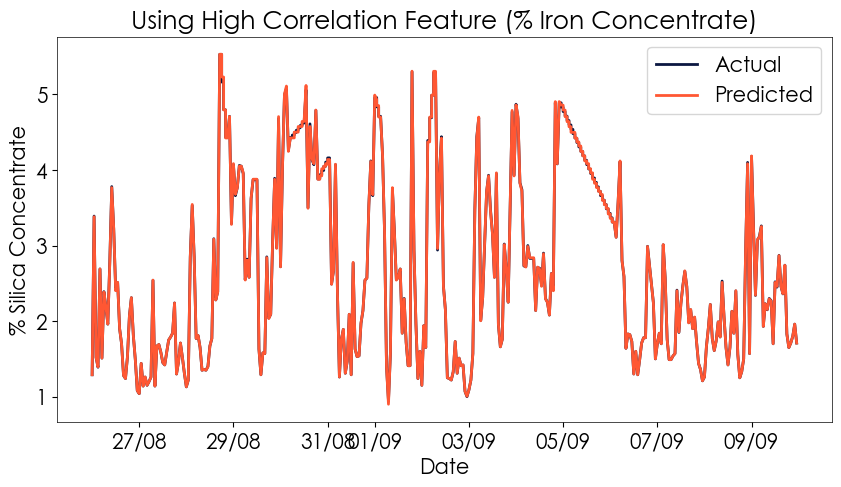

In [134]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(y_test.index, y_test, label='Actual', c='#0B1741')
ax.plot(y_test.index, y_pred, label='Predicted', c='#FF5733')   

ax.set_ylabel('% Silica Concentrate')
ax.set_xlabel('Date')
ax.legend(loc='upper right')
ax.set_title('Using High Correlation Feature (% Iron Concentrate)')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))

fig.savefig(r'G:\Meu Drive\03 - Facens\03 - Data Science\02-TCC-POS\05-Figures\bm_sc_prediction_02.svg', dpi=140, format='svg')

plt.show()